# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/285 Final Project/CodeRL

/content/drive/MyDrive/285 Final Project/CodeRL


In [3]:
# Download Critic
# !gsutil -m cp \
#   "gs://sfr-coderl-research/codet5_finetuned_critic/config.json" \
#   "gs://sfr-coderl-research/codet5_finetuned_critic/pytorch_model.bin" \
#   .

In [ ]:
!pip install -r requirements.txt

In [ ]:
%cd transformers
!pip install -e .
%cd ..

In [6]:
import json
import pickle
import time
import os

# Step 1: Generate programs

In [ ]:
import sys
sys.set_int_max_str_digits(10000) # fix for

In [ ]:
!chmod +x scripts/generate_tony_ucb.sh
!scripts/generate_tony_ucb.sh
# error 3028 4068

# Step 2: Run unit test & Analysis

In [ ]:
import gc
gc.collect()

25

In [ ]:
!chmod +x scripts/run_unit_tests_tony.sh
!scripts/run_unit_tests_tony.sh
# model b: 4000-4500 | 0-500

# RunTime Analysis Plot

In [ ]:
import time
# Required libraries
import os
import pickle
import pandas as pd
from datetime import timedelta

# Directory containing pickle files
directory_path = 'outputs/train/test_results'  # Change this to your directory path

# List pickle files
pickle_files = [file for file in os.listdir(directory_path) if file.endswith('.pkl')]
problem_id_to_runtime = {}
# Function to load and display pickle file content
def load_and_display_pickle(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        test_id, data = next(iter(data.items()))
        results = data['results']
        times = data['times']
        error_types = data['errors']
        times_ms = []
        run_time_on_first_test = []
        for problem in times:
          temp = [] # program without run-time error
          for program in problem:
            if program: temp.append(program.microseconds/1000)
          times_ms.append(temp)
          if len(temp)>1:
            run_time_on_first_test.append(temp[0])
        problem_id_to_runtime[test_id] = run_time_on_first_test
        print(test_id)
        print(results)
        print(error_types)
        print(times_ms)
        print(run_time_on_first_test)
        print('-'*50)

# Display info for each pickle file
for pickle_file in pickle_files:
    print(pickle_file)
    if int(pickle_file.split('.')[0])>4757:
      file_path = os.path.join(directory_path, pickle_file)
      load_and_display_pickle(file_path)


In [ ]:
for problem_id in sorted(problem_id_to_runtime.keys()):
    print(problem_id, ":", problem_id_to_runtime[problem_id])

In [ ]:
# Load the JSON content
import json
file_path = "./outputs/codes/79.json"
with open(file_path, 'r') as json_file:
    data = json.load(json_file)
    # Extract the code entries
    code_entries = data["79"]["code"]

    # Print each code entry in a readable way
    for idx, code in enumerate(code_entries, 1):
        print(f"Program {idx}:\n")
        print(code)
        print("\n" + "-"*50 + "\n")



"""
3 5 6 7
[[False], [False], [True, True, False], [False], [True, False], [True, False], [True, True, False], [False], [False], [-1]]
[[97.291], [34.03], [19.779, 39.269, 15.357], [17.657], [9.676, 57.814], [44.509, 57.307], [31.226, 48.81, 31.1], [33.978], [23.07], []]
[19.779, 9.676, 44.509, 31.226]

"""

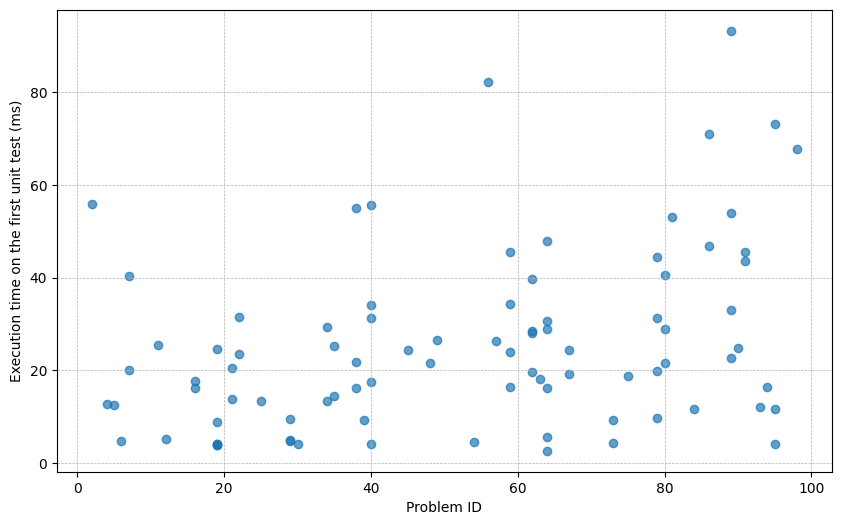

In [ ]:
import matplotlib.pyplot as plt
# Preparing data for scatter plot
problem_ids = []
runtimes = []

for problem_id, runtime_list in problem_id_to_runtime.items():
    for runtime in runtime_list:
        problem_ids.append(problem_id)
        runtimes.append(runtime)

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(problem_ids, runtimes, marker='o', alpha=0.7)

# Adding labels and title
plt.xlabel('Problem ID')
plt.ylabel('Execution time on the first unit test (ms)')
# plt.title('Execution Time Distribution for 100 Competitive Programming Problems')
"""
Figure 1: Execution times for 10 programs generated per each of the 100 competitive programming problems. Times are displayed only for programs that passed at least one unit test.
"""
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


# Step 3: Data Migration

The following script will take all the pkl files in test_results_dir, convert them into json, and save into the corresponding problem subdirectory under destination_root_dir.

In [ ]:
test_results_dir = 'outputs/test/test_results/'
destination_root_dir = 'data/APPS/test/'

In [ ]:
def pkl_to_json(pkl_file_path):
  with open(pkl_file_path, 'rb') as file:
    data = pickle.load(file)
    problem_id, data = next(iter(data.items()))
    print(f'Processing problem {problem_id}')
    results = data['results']
    times = data['times']
    codes = data['sols']

    json_data = []
    for i in range(len(results)):
      result = results[i] # result could be [-1] [-2] [F] [T,T,T,F] [T,T,T,T,T,T]
      time = None
      # print(f'Results: {result}')
      if len(result)==1 and (result[0]==-1 or result[0]==-2):
        result = result[0]
      else:
        # True only if the program passed all the unit tests
        if result[-1]==True:
          result = True
        else:
          result = False
        if result:
          time = 0
          print(times[i])
          # Calculate the time as the total time of passing all the unit tests
          for time_obj in times[i]:
            time+=time_obj.microseconds/1000
          print(f'Total Time: {time}')
      json_data.append({'code':codes[i],
                        'result':result,
                        'time':time})
    json_file_path = destination_root_dir+str(problem_id).zfill(4)+'/gen_solutions.json'
    with open(json_file_path, 'w') as file:
        json.dump(json_data, file)
        print('Saved json at '+json_file_path)


In [ ]:
entries = os.listdir(test_results_dir)
file_names = [entry for entry in entries if os.path.isfile(os.path.join(test_results_dir, entry))]
for file_name in file_names:
  pkl_to_json(test_results_dir+file_name)

# Step 4: Generate critic scores

In [ ]:
!chmod +x scripts/generate_critic_scores.sh
!scripts/generate_critic_scores.sh

# Step 5: RL Training

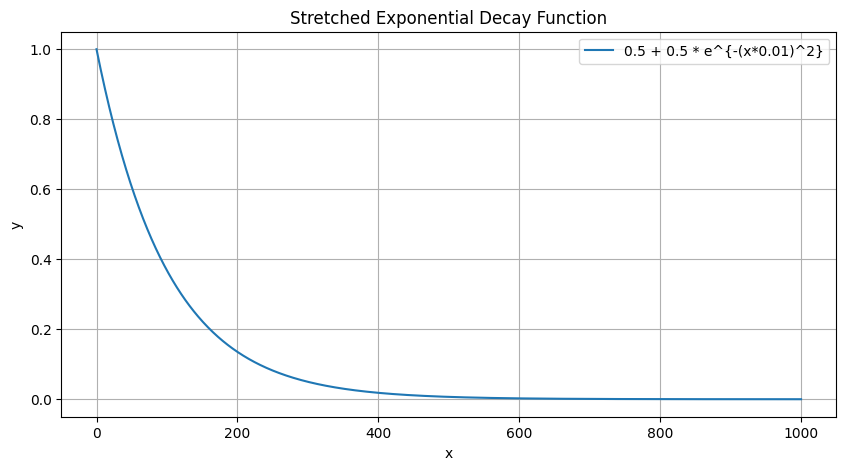

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define the new range of x values
x_stretched = np.linspace(0, 1000, 1000)

# Define the stretched function
y_stretched = np.exp(-0.01*(x_stretched))

# Plot the stretched function
plt.figure(figsize=(10, 5))
plt.plot(x_stretched, y_stretched, label='0.5 + 0.5 * e^{-(x*0.01)^2}')
plt.title('Stretched Exponential Decay Function')
plt.xlabel('x')
plt.ylabel('y')
# plt.ylim(0, 1)
# plt.xlim(0,1000)
plt.legend()
plt.grid(True)
plt.show()

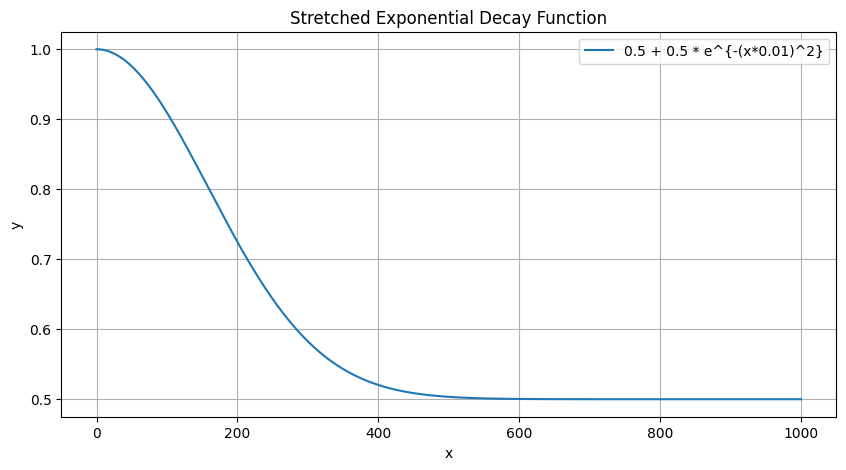

In [ ]:
# Define the new range of x values
x_stretched = np.linspace(0, 1000, 1000)

# Define the stretched function
y_stretched = 0.5 + 0.5 * np.exp(-0.00002*(x_stretched) ** 2)

# Plot the stretched function
plt.figure(figsize=(10, 5))
plt.plot(x_stretched, y_stretched, label='0.5 + 0.5 * e^{-(x*0.01)^2}')
plt.title('Stretched Exponential Decay Function')
plt.xlabel('x')
plt.ylabel('y')
# plt.ylim(0, 1)
# plt.xlim(0,1000)
plt.legend()
plt.grid(True)
plt.show()

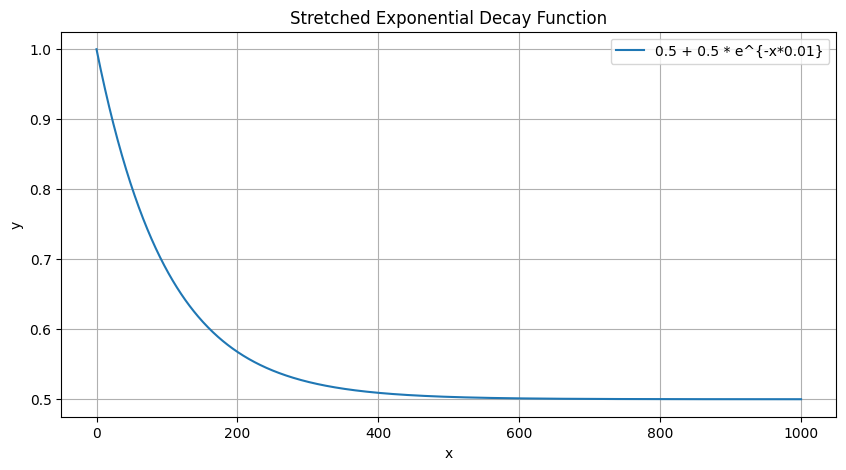

In [ ]:
# Define the new range of x values
x_stretched = np.linspace(0, 1000, 1000)

# Define the stretched function
y_stretched = 0.5 + 0.5 * np.exp(-x_stretched*0.01)

# Plot the stretched function
plt.figure(figsize=(10, 5))
plt.plot(x_stretched, y_stretched, label='0.5 + 0.5 * e^{-x*0.01}')
plt.title('Stretched Exponential Decay Function')
plt.xlabel('x')
plt.ylabel('y')
# plt.ylim(0, 1)
# plt.xlim(0,1000)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# To read the results
# load the above json file
with open('models_eval/train_gen_results_runtimes.json', 'r') as file:
    data = json.load(file)

[None, None, 13.622, None, None, 33.699, 43.543, 30.493, None, 10.489]
[[False], [False], [True], [False], [False], [True], [True], [True], [False], [True]]


In [ ]:
print(data['110']['runtimes'])
print(data['110']['results'])

[None, None, None, None, None, None, None, None, None, None]
[[False], -1, -1, [False], [False], -1, -1, [False], [False], -1]


In [ ]:
!chmod +x scripts/train_actor_rl.sh
!scripts/train_actor_rl.sh